In [8]:
%matplotlib inline

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pylab

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

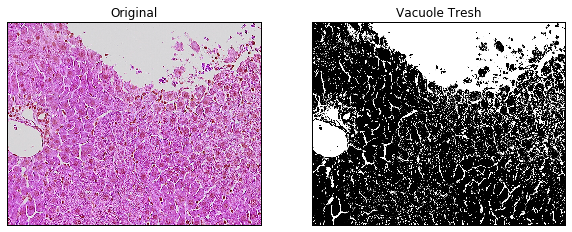

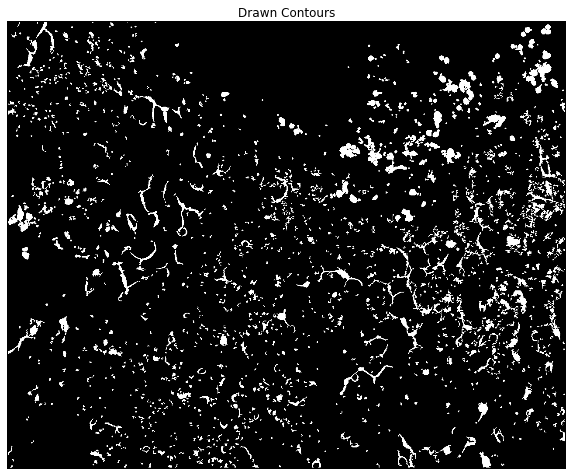

(<matplotlib.image.AxesImage at 0x20f6343a128>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [10]:
#----------------------------EMPTY VACUOLE DETECTION---------------------------------
img = cv2.imread("HEImgs/Image_87HE_Prj7_L84a_001_064.tif")

plt.subplot(121), plt.title("Original"), plt.imshow(img), plt.xticks([]), plt.yticks([])

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

vacuole_thresh = cv2.inRange(mask, (0,70,0), (255,255,255))
vacuole_thresh = 255 - vacuole_thresh

plt.subplot(122), plt.imshow(vacuole_thresh, cmap = 'gray'), plt.title("Vacuole Tresh"), plt.xticks([]), plt.yticks([]), plt.show()

_, vacuole_cnt, _ = cv2.findContours(vacuole_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
vacuole_img = np.zeros(vacuole_thresh.shape, np.uint8)
for c in vacuole_cnt:
    if cv2.contourArea(c) <= 750 and cv2.contourArea(c) > 5:
        (x,y),(MA,ma),angle = cv2.fitEllipse(c)
        if MA/ma >= 0.4:
            cv2.drawContours(vacuole_img, [c], 0, 255, -1)
    
plt.imshow(vacuole_img, cmap = 'gray'), plt.title("Drawn Contours"), plt.xticks([]), plt.yticks([]), plt.show()

No bubble detected


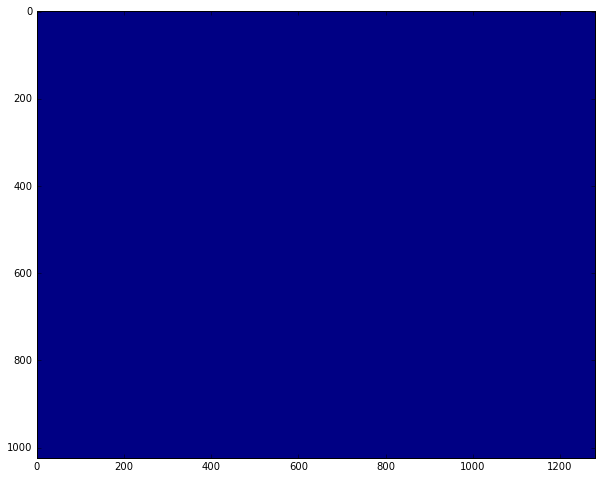

In [11]:
#-------------------------------BUBBLE DETECTION---------------------------------------
img = cv2.imread("HEImgs/Image_87HE_Prj7_L84a_002_042.tif")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
_, c, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = c[0]
x,y,w,h = cv2.boundingRect(cnt)
crop = gray[y:h+y, x:x+w]

mask = np.zeros(crop.shape, np.uint8)
_, t2 = cv2.threshold(crop, 87, 255, cv2.THRESH_BINARY)
_, contours, _ = cv2.findContours(t2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

areaArray = []
count = 1
for i, c in enumerate(contours):
    areaArray.append(cv2.contourArea(c))
    
c = []
sorteddata = sorted(zip(areaArray, contours), key = lambda x: x[0], reverse= True)
for i in range(len(sorteddata)):
    cnt = sorteddata[i][1]
    leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
    rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
    bottommost = tuple(cnt[cnt[:,:,1].argmin()][0])
    topmost = tuple(cnt[cnt[:,:,1].argmax()][0])
    
    if (((leftmost[0] <= 2) and (bottommost[1] <= 2) and (rightmost[0] >= crop.shape[1]-2) and (topmost[1] >= crop.shape[0]-2)) == 0):
        area = cv2.contourArea(cnt)
        if (area >= 10000.0):
            perimeter = cv2.arcLength(cnt, True)
            if (perimeter != 0.0):
                if ((4*np.pi*area)/(perimeter*perimeter) >= 0.40):
                    c = cnt
        
if len(c) == 0:
        print("No bubble detected")
        plt.imshow(thresh)
        plt.show()
else:
        cv2.drawContours(mask, c, -1, (255,0,0), 2)
        cv2.imshow("Contours", mask)
        cv2.waitKey(-1)

In [12]:
# Given 3 points on circle, finds center of circle (Identifies circles vs. rectangles)

valid_points = []
for point in c:
    x = float(point[0][0])
    y = float(point[0][1])
    if (x <= 5 or y <=5 or x >= img.shape[1]-5 or y >= img.shape[0]-5) == 0:
        valid_points.append((x,y))
        
index = len(valid_points)
parts = int(index/3)

point = ["","",""]
mean_x = []
mean_y = []
for i in range(parts-1):
    for j in range(3):
        point[j] = valid_points[(parts*j)+i]
        
    m1 = 0.0
    if point[0][0] != point[1][0]:
        m1 = (point[1][1] - point[0][1])/(point[1][0]-point[0][0])
        
    m2 = 0.0
    if point[2][0] != point[1][0]:
        m2 = (point[2][1]-point[1][1])/(point[2][0]-point[1][0])
        
    if m1 != 0.0 and m2-m1 != 0.0:
        center_x = (m1*m2*(point[0][1]-point[2][1])+m2*(point[0][0]+point[1][0]) - m1*(point[1][0]+point[2][0]))/(2*(m2-m1))
        
        center_y = ((-1.0/m1)*(center_x-((point[0][0]+point[1][0])/2))) + ((point[0][1]+point[1][1])/2)
        
        cv2.circle(mask, (int(center_x), int(center_y)),5,(255,255,255),4)
        
        mean_x.append(center_x)
        mean_y.append(center_y)
    else:
        pass
if len(mean_x) != 0.0:    
    print(np.std(mean_x))
    print(np.std(mean_y))
    cv2.circle(mask,(int(np.mean(mean_x)), int(np.mean(mean_y))), 32, (255,255,255),4)
    cv2.drawContours(mask,c,-1,(255,0,0),2)
    cv2.imshow("Contours", mask)
    cv2.waitKey(-1)

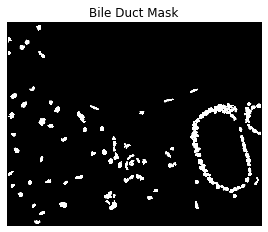

(<matplotlib.image.AxesImage at 0x20f632f0390>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [13]:
#-------------------------------------BILE DUCT DETECTION------------------------------------------------
img = cv2.imread("HEImgs/Image_87HE_Prj7_L84a_001_069.tif")

plt.subplot(121), plt.title("Original"), plt.imshow(img), plt.xticks([]), plt.yticks([])

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

bile_thresh = cv2.inRange(mask, (185,0,0), (195,255,255))
_, bile_duct_cnt, _ = cv2.findContours(bile_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
bile_mask = np.zeros(bile_thresh.shape, np.uint8)
for c in bile_duct_cnt:
    if cv2.contourArea(c) > 100:
        cv2.drawContours(bile_mask, [c], 0, 255, -1)
        
kernel = np.ones((3,3), np.uint8)
duct_dilation = cv2.dilate(bile_mask, kernel, iterations=2)
                     
plt.imshow(duct_dilation, cmap = 'gray'), plt.title("Bile Duct Mask"), plt.xticks([]), plt.yticks([]), plt.show()

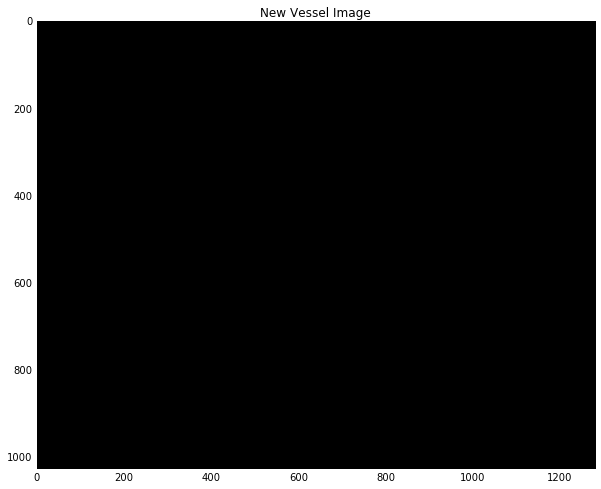

(<matplotlib.image.AxesImage at 0x20f632bacc0>,
 None)

In [21]:
#----------------------------------VESSEL DETECTION----------------------------------------
img = cv2.imread("HEImgs/Image_87HE_Prj7_L84a_001_126.tif")

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

thresh = cv2.inRange(mask, (0,40,0), (255,255,255))
thresh = 255 - thresh

_, vessel_cnt, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
new_vessel = np.zeros(thresh.shape, np.uint8)
for c in vessel_cnt:
    if cv2.contourArea(c) > 2000:
        perimeter = cv2.arcLength(c, True)
        if (4*np.pi*cv2.contourArea(c))/(perimeter*perimeter) >= 0.1:
            cv2.drawContours(new_vessel, [c], 0, 255, -1)
    
plt.imshow(new_vessel, cmap = 'gray'), plt.title("New Vessel Image"), plt.show()